In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import seaborn as sns

sns.set_style('darkgrid')

In [329]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, dt = 1.0, target_alt = 1.0, thrust_gs= 1.2, g = 1.0,
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-thrust_gs]), 
                                           high=np.array([thrust_gs]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot)
        self.observation_space = gym.spaces.Box(low=np.array([-10,-10]), 
                                                high=np.array([10,10]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target r in natural units
        self.dt = dt
        self.record_rate = record_rate
        self.max_thrust = thrust_gs
        self.max_steps = 200
        self.g = g
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = np.clip(np.random.normal(0.0,2.5),a_min = -5.0, a_max=5.0)
        self.r_dot = np.clip(np.random.normal(0.0,0.5),a_min = -1.0, a_max=1.0)
        self.r_double_dot = 0.0

        self.episode_steps = 0
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0], -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.episode_steps += 1

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot]],axis=0)
        
        reward = -(self.r/10.0)**2
        
        # set if at the terminal state
        done = False
        
        if np.abs(self.r) < 0.01 and np.abs(self.r_dot) < 0.01:
            reward = 1.0
        
        # test for terminal state
        if np.abs(self.r) > 10.0 or np.abs(self.r_dot) > 5.0:
            done = True
        
        if self.episode_steps > self.max_steps:
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

In [330]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs]).to(device)
            mu_v = net(obs_v)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            obs, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.LongTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v


HIDDEN_SIZE = 128

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGActor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, act_size)
        )

    def forward(self, x):
        return self.net(x)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))
    
class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True, ou_mu=0.0, 
                 ou_teta=0.0, ou_sigma=1.0, ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        sigma = np.ones(1)*self.ou_sigma

        if self.ou_enabled and self.ou_epsilon > 0:
            '''
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
            '''
            actions = actions + np.random.normal(0.0, sigma, actions.shape)
            new_a_states = actions
        else:
            new_a_states = agent_states

        #actions = np.clip(actions, -1, 1)
        return actions, new_a_states

In [331]:
GAMMA = 0.99
TAU = 0.01

BATCH_SIZE = 512
LEARNING_RATE = 1e-4

REPLAY_SIZE = 100000
REPLAY_INITIAL = 10000

TEST_ITERS = 1000

env = UniformGravity(dt = 0.05, g = 0.0, record_history=False)
test_env = UniformGravity(dt = 0.05, g = 0.0, record_history=True)

In [332]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

print(act_net)
print(crt_net)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)

agent = AgentDDPG(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)

buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

DDPGActor(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
DDPGCritic(
  (obs_net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
  )
  (out_net): Sequential(
    (0): Linear(in_features=129, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [333]:
frame_idx = 0
best_reward = None

while True:
    frame_idx += 1
    buffer.populate(1)
    #rewards_steps = exp_source.pop_rewards_steps()

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)
    
    agent.ou_sigma = np.max([(1-1./1e5)*agent.ou_sigma, 0.25])

    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)

    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()


    tgt_act_net.alpha_sync(alpha=1 - TAU)
    tgt_crt_net.alpha_sync(alpha=1 - TAU)

    if frame_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(act_net, test_env, device=device)
        print("Test done in %.2f sec, avg reward %.3f, avg steps %d" % 
              (time.time() - ts, rewards, steps))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
                name = "best_%+.3f_%d.dat" % (rewards, frame_idx)
            best_reward = rewards
        
        if best_reward > 50.00:
            print('solved.')
            break

Test done in 0.44 sec, avg reward -14.954, avg steps 150
Test done in 0.27 sec, avg reward -15.819, avg steps 76
Test done in 0.30 sec, avg reward -13.836, avg steps 76
Best reward updated: -14.954 -> -13.836
Test done in 0.38 sec, avg reward -22.780, avg steps 114
Test done in 0.67 sec, avg reward -1.785, avg steps 201
Best reward updated: -13.836 -> -1.785
Test done in 0.70 sec, avg reward -3.007, avg steps 201
Test done in 0.64 sec, avg reward -3.355, avg steps 201
Test done in 0.75 sec, avg reward -1.128, avg steps 201
Best reward updated: -1.785 -> -1.128
Test done in 0.67 sec, avg reward -3.508, avg steps 201
Test done in 0.64 sec, avg reward -4.011, avg steps 201
Test done in 0.73 sec, avg reward -2.953, avg steps 201
Test done in 0.65 sec, avg reward -2.981, avg steps 201
Test done in 0.67 sec, avg reward -2.060, avg steps 201
Test done in 0.62 sec, avg reward -4.304, avg steps 201
Test done in 0.65 sec, avg reward -2.996, avg steps 201
Test done in 0.66 sec, avg reward -2.850,

KeyboardInterrupt: 

In [343]:
many_traj = []
many_a = []

for _ in range(1):
    traj = []
    a_history = []
    
    s = test_env.reset()
    while True:
        traj.append(s)
    
        s_v = torch.FloatTensor([s]).to(device)
        a_v = act_net(s_v)
        a = a_v.data.cpu().numpy()[0]
        a_history.append( np.clip(a, -test_env.max_thrust, test_env.max_thrust))
    
        s,r,d,_ = test_env.step(a)
        if d:
            break

    many_traj.append(np.array(traj))
    many_a.append(np.array(a_history))

many_traj = np.array(many_traj)
many_a = np.array(many_a)

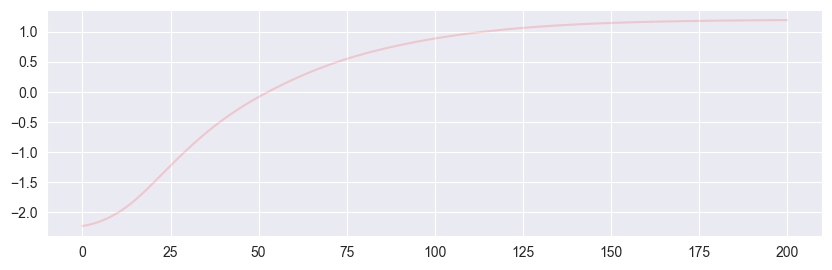

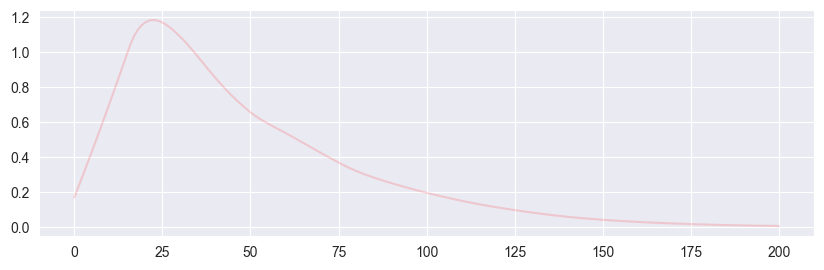

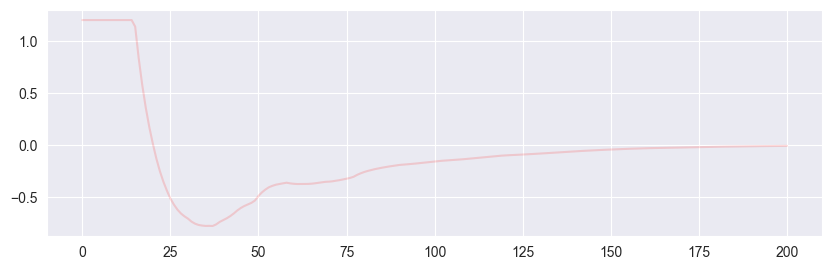

In [344]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,0].T, color='r', alpha=0.15);
plt.show();

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_traj[:,:,1].T, color='r', alpha=0.15);
plt.show()

plt.figure(figsize=(10,3), dpi=100)
plt.plot(many_a[:,:,0].T, color='r', alpha=0.15);
plt.show()